In [ ]:
!pip install matplotlib

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Air_Humidity.csv to Air_Humidity.csv
Saving Air_temperature.csv to Air_temperature.csv
Saving rainfall.csv to rainfall (10).csv


**Data preprocessing**

In [ ]:
init_data = {}
init_data = pd.DataFrame(init_data)
for key in uploaded.keys():
  data = uploaded[key].decode("utf-8").split("\n")
  for i in range(len(data)):
    data[i] = data[i].split(",")
  df_init = pd.DataFrame(data)
  df = df_init.iloc[1:,1:]
  # print(df,df.shape)

  #key[:-4] = df[1]
  init_data[key[:-4]] = df[11]

In [ ]:
print(init_data.columns)
for col in init_data.columns:
  init_data[col] = pd.to_numeric(init_data[col])
print(init_data)

Index(['Air_Humidity', 'Air_temperature', 'rainfall'], dtype='object')
       Air_Humidity  Air_temperature   rainfall
1             47.75        295.30000  23.589996
2             52.00        295.30000  24.710007
3             48.50        295.77002  24.020004
4             45.75        296.12000  24.069992
5             43.75        296.77002  24.319992
...             ...              ...        ...
26294         64.00        297.47498  28.575000
26295         63.75        295.40000  26.125000
26296         53.75        294.90000  24.375000
26297         55.00        295.27496  28.450000
26298         61.75        295.32498  28.425000

[26298 rows x 3 columns]


**Prediction of time series for rainfall,humidity and air data using LSTM**

In [ ]:
import tensorflow as tf
import keras
from keras.layers import LSTM,Dense,Bidirectional,Flatten
from math import sqrt
from numpy import concatenate
from sklearn.metrics import mean_squared_error

In [ ]:
def series_to_supervised(data, n_in, n_out, dropnan=True):
    n_vars = 1 if n_feature is 1 else data.shape[1]
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
      cols.append(data.shift(i))
      names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
      cols.append(data.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
      agg.dropna(inplace=True)
    return agg

print(init_data)

init_data_copy = init_data.copy()
n_timeLag = 7
n_feature = 2

reframed = series_to_supervised(init_data[['Air_Humidity','rainfall']], n_timeLag, 1)
print(reframed)
print(reframed.head())

       Air_Humidity  Air_temperature   rainfall
1             47.75        295.30000  23.589996
2             52.00        295.30000  24.710007
3             48.50        295.77002  24.020004
4             45.75        296.12000  24.069992
5             43.75        296.77002  24.319992
...             ...              ...        ...
26294         64.00        297.47498  28.575000
26295         63.75        295.40000  26.125000
26296         53.75        294.90000  24.375000
26297         55.00        295.27496  28.450000
26298         61.75        295.32498  28.425000

[26298 rows x 3 columns]
       var1(t-7)  var2(t-7)  var1(t-6)  ...  var2(t-1)  var1(t)    var2(t)
8          47.75  23.589996      52.00  ...  22.270004    43.50  17.739990
9          52.00  24.710007      48.50  ...  17.739990    42.50  19.119995
10         48.50  24.020004      45.75  ...  19.119995    42.00  18.459991
11         45.75  24.069992      43.75  ...  18.459991    42.50  17.540009
12         43.75  24.31

In [ ]:
values = reframed.values
n_train = 22000

#print(scaler.inverse_transform(values))
#print(values)
train = values[:n_train, :]
test = values[n_train:, :]

# split into input and outputs
train_X, train_y = train[:, :n_timeLag*n_feature], train[:, -1:]
X_scaler = MinMaxScaler()
X_scaler.fit(train_X)
train_X = X_scaler.transform(train_X)
y_scaler = MinMaxScaler()
y_scaler.fit(train_y)
train_y = y_scaler.transform(train_y)

test_X, test_y = test[:, :n_timeLag*n_feature], test[:, -1:]
test_X = X_scaler.transform(test_X)
test_y = y_scaler.transform(test_y)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_timeLag, n_feature))
test_X = test_X.reshape((test_X.shape[0], n_timeLag, n_feature))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(train_X,train_y)

(22000, 7, 2) (22000, 1) (4291, 7, 2) (4291, 1)
[[[0.48472239 0.36082978]
  [0.52786522 0.37972336]
  [0.49233583 0.36808363]
  ...
  [0.44411737 0.37314416]
  [0.50756271 0.38242222]
  [0.47710895 0.33856271]]

 [[0.52786522 0.37972336]
  [0.49233583 0.36808363]
  [0.46441988 0.36892689]
  ...
  [0.50756271 0.38242222]
  [0.47710895 0.33856271]
  [0.44157956 0.26214545]]

 [[0.49233583 0.36808363]
  [0.46441988 0.36892689]
  [0.44411737 0.37314416]
  ...
  [0.47710895 0.33856271]
  [0.44157956 0.26214545]
  [0.4314283  0.28542489]]

 ...

 [[0.70804998 0.7071524 ]
  [0.68774747 0.62027662]
  [0.70043654 0.72621457]
  ...
  [0.92630195 0.52446001]
  [0.68013403 0.43302952]
  [0.5430921  0.49730076]]

 [[0.68774747 0.62027662]
  [0.70043654 0.72621457]
  [0.86539442 0.69736829]
  ...
  [0.68013403 0.43302952]
  [0.5430921  0.49730076]
  [0.57100805 0.51450731]]

 [[0.70043654 0.72621457]
  [0.86539442 0.69736829]
  [0.92630195 0.52446001]
  ...
  [0.5430921  0.49730076]
  [0.57100805 0.

22000 samples used for training and 4291 samples for testing

1100/1100 - 4s - loss: 0.0708 - val_loss: 0.0653
0
1100/1100 - 3s - loss: 0.0464 - val_loss: 0.0457
1
1100/1100 - 3s - loss: 0.0406 - val_loss: 0.0432
2
1100/1100 - 3s - loss: 0.0401 - val_loss: 0.0436
3
1100/1100 - 3s - loss: 0.0393 - val_loss: 0.0422
4
1100/1100 - 3s - loss: 0.0389 - val_loss: 0.0424
5
1100/1100 - 3s - loss: 0.0388 - val_loss: 0.0426
6
1100/1100 - 3s - loss: 0.0387 - val_loss: 0.0425
7
1100/1100 - 3s - loss: 0.0385 - val_loss: 0.0420
8
1100/1100 - 3s - loss: 0.0384 - val_loss: 0.0419
9
1100/1100 - 3s - loss: 0.0383 - val_loss: 0.0419
10
1100/1100 - 3s - loss: 0.0384 - val_loss: 0.0416
11
1100/1100 - 3s - loss: 0.0383 - val_loss: 0.0417
12
1100/1100 - 3s - loss: 0.0383 - val_loss: 0.0418
13
1100/1100 - 3s - loss: 0.0382 - val_loss: 0.0416
14
1100/1100 - 3s - loss: 0.0381 - val_loss: 0.0419
15
1100/1100 - 3s - loss: 0.0382 - val_loss: 0.0420
16
1100/1100 - 3s - loss: 0.0383 - val_loss: 0.0421
17
1100/1100 - 3s - loss: 0.0381 - val_loss: 0.0421
18
1100/1100 - 3s - loss:

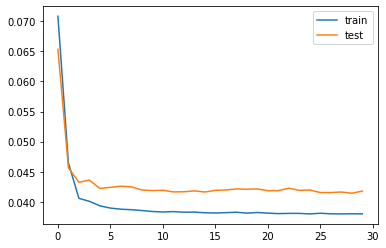

In [ ]:
# design network
err_train,err_test = list(),list()
model = keras.Sequential()
#model.add(Bidirectional(LSTM(35, return_sequences=True), input_shape=(train_X.shape[1], train_X.shape[2]), merge_mode='concat'))
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(Flatten())
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
for i in range(30):
  history = model.fit(train_X, train_y, epochs=1, batch_size=20, validation_data=(test_X, test_y), verbose=2, shuffle=False)
  err_test.append(history.history['val_loss'])
  err_train.append(history.history['loss'])
  print(i)
  model.reset_states()
  # plot history

 
print(err_train)
plt.plot(err_train, label='train')
plt.plot(err_test, label='test')
plt.legend()
plt.show()

[[31.199997]
 [29.350006]
 [27.149994]
 ...
 [24.375   ]
 [28.45    ]
 [28.425   ]] [[32.770695]
 [30.122684]
 [28.893751]
 ...
 [27.331457]
 [24.731066]
 [31.33591 ]]


error values for LSTM predictions:
	Mean Absolute Error: 2.4759318583347216
	Mean Squared Error: 10.719752050500604
	Root Mean Squared Error: 3.2741032437143156


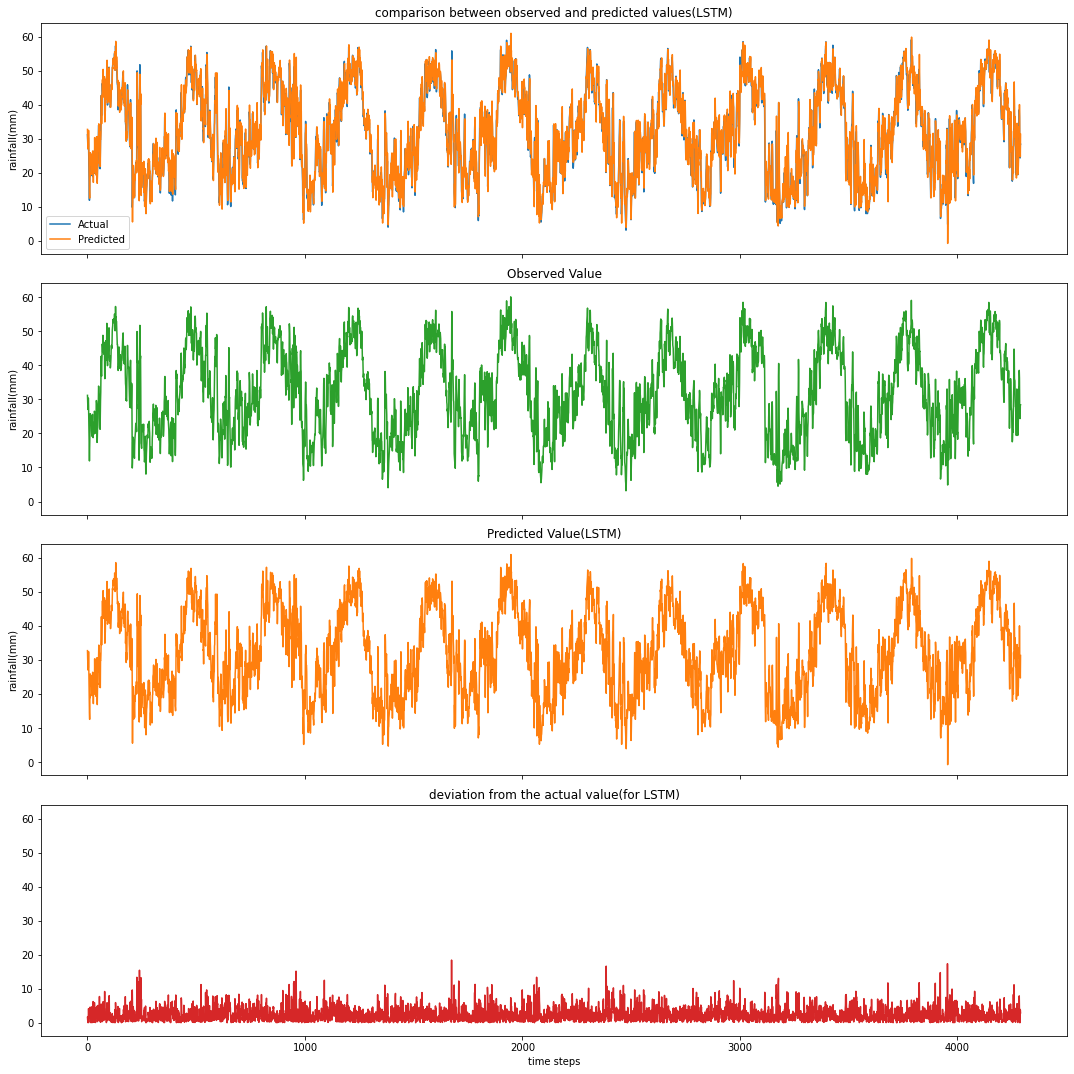

In [ ]:
# make a prediction
yhat = model.predict(test_X)
#yhat = scaler.inverse_transform(yhat)
#test_X = test_X.reshape((test_X.shape[0], 21))
# invert scaling for actual
test_y = y_scaler.inverse_transform(test_y)
yhat = y_scaler.inverse_transform(yhat)

test_y = test_y.reshape((len(test_y), 1))

print(test_y,yhat)

# calculate errors
print("\n\nerror values for LSTM predictions:")
print('\tMean Absolute Error:', metrics.mean_absolute_error(test_y, yhat))
print('\tMean Squared Error:', metrics.mean_squared_error(test_y, yhat))
print('\tRoot Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y, yhat)))


fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,sharex=True, sharey=True)
fig.set_figheight(15)
fig.set_figwidth(15)
#fig.suptitle('Rainfall Forecast')
ax0.plot(test_y)
ax0.plot(yhat)
ax0.set_title('comparison between observed and predicted values(LSTM)')
ax0.legend(['Actual','Predicted'])
ax0.set_ylabel('rainfall(mm)')
ax1.plot(test_y, 'tab:green')
ax1.set_ylabel('rainfall(mm)')
ax1.set_title('Observed Value')
ax2.plot(yhat, 'tab:orange')
ax2.set_ylabel('rainfall(mm)')
ax2.set_title('Predicted Value(LSTM)')
ax3.plot(abs(test_y-yhat), 'tab:red')
ax3.set_title('deviation from the actual value(for LSTM)')
ax3.set_xlabel('time steps')
#plt.xticks(list(range(0,init_data.shape[0],400)))
fig.tight_layout(pad=1.0)
plt.show()

#fig = plt.subplots(1)
#print(list(range(0,df.shape[0]-n_train,200)),np.array(df_init.iloc[list(range(n_train,df.shape[0],200)),0]))



yhat is the series predicted by LSTM

yhat[:,2] is the rainfall value predicted by LSTM

Air_Humidity       729.237464
Air_temperature     16.216020
rainfall           158.107022
dtype: float64


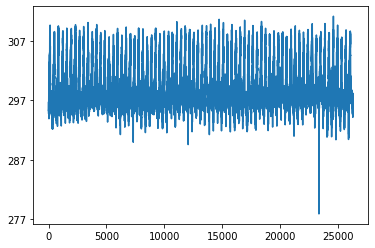

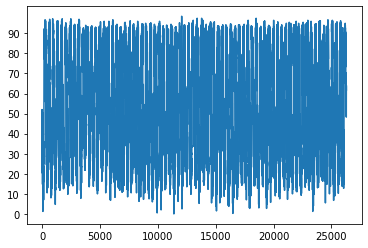

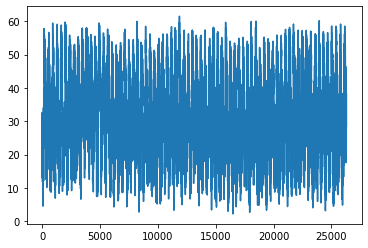

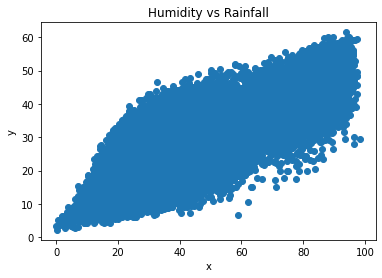

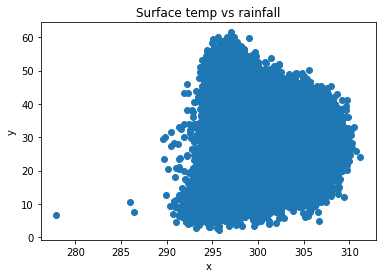

In [ ]:
print(init_data.var())

plt.plot(init_data['Air_temperature'])
plt.yticks(list(range(int(init_data['Air_temperature'].min()),int(init_data['Air_temperature'].max()),10)))
plt.show()
plt.plot(init_data['Air_Humidity'])
plt.yticks(list(range(0,int(init_data['Air_Humidity'].max()),10)))
plt.show()
plt.plot(init_data['rainfall'])
plt.yticks(list(range(0,int(init_data['rainfall'].max()),10)))
plt.show()
plt.scatter(init_data['Air_Humidity'], init_data['rainfall']) 
plt.xlabel('x') 
plt.ylabel('y') 
plt.title("Humidity vs Rainfall") 
plt.show()
plt.scatter(init_data['Air_temperature'], init_data['rainfall']) 
plt.xlabel('x') 
plt.ylabel('y') 
plt.title("Surface temp vs rainfall")
plt.show() 

In [ ]:
X_train,  y_train  = init_data.iloc[:22000,0:2], init_data.iloc[:22000,2]
X_test,y_test = init_data.iloc[22000:,0:2], init_data.iloc[22000:,2]

print(init_data['rainfall'])
print(y_test.shape)
#X_train, y_train = np.asarray(init_data.iloc[:,0:2]), np.asarray(init_data.iloc[:,2])
#X_test = yhat[:,:2]
print(X_train,X_train.shape)
print(X_test , y_test )


1        23.589996
2        24.710007
3        24.020004
4        24.069992
5        24.319992
           ...    
26294    28.575000
26295    26.125000
26296    24.375000
26297    28.450000
26298    28.425000
Name: rainfall, Length: 26298, dtype: float64
(4298,)
       Air_Humidity  Air_temperature
1             47.75        295.30000
2             52.00        295.30000
3             48.50        295.77002
4             45.75        296.12000
5             43.75        296.77002
...             ...              ...
21996         35.25        303.10000
21997         42.50        301.18000
21998         69.75        297.80000
21999         67.75        298.65002
22000         69.00        298.78000

[22000 rows x 2 columns] (22000, 2)
       Air_Humidity  Air_temperature
22001         85.25        297.22998
22002         91.25        296.25000
22003         67.00        298.88000
22004         53.50        300.53000
22005         56.25        300.03000
...             ...              .

X_test contains 6291 samples of humidity and air data predicted by LSTM

**Prediction using Linear Regression**

In [ ]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred_lr = regressor.predict(X_test)
df_lr = pd.DataFrame({'Actual': y_test ,'Predicted': y_pred_lr})
df_lr

,Actual,Predicted
22001,43.539993,45.554459
22002,33.289993,47.167617
22003,27.869995,38.362906
22004,31.679993,33.780458
22005,32.699997,34.432528
...,...,...
26294,28.575000,34.302652
26295,26.125000,30.602652
26296,24.375000,24.251243
26297,28.450000,25.581653


y_pred_lr is the rainfall value predicted using Linear Regression

In [ ]:
print("error values for LinearRegression predictions:")
print('\tMean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_lr))
print('\tMean Squared Error:', metrics.mean_squared_error(y_test, y_pred_lr))
print('\tRoot Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_lr)))

#print("\n\nerror values for LSTM predictions:")
#print('\tMean Absolute Error:', metrics.mean_absolute_error(test_y, yhat[:,2]))
#print('\tMean Squared Error:', metrics.mean_squared_error(test_y[:,2], yhat[:,2]))
#print('\tRoot Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y[:,2], yhat[:,2])))

error values for LinearRegression predictions:
	Mean Absolute Error: 3.5983518297155723
	Mean Squared Error: 21.409403085232437
	Root Mean Squared Error: 4.627029617933349


**prediction using Multiple Linear Regression**

          Actual  Predicted
22001  43.539993  45.242045
22002  33.289993  48.041289
22003  27.869995  36.307558
22004  31.679993  29.704324
22005  32.699997  31.047198
...          ...        ...
26294  28.575000  34.816081
26295  26.125000  34.665169
26296  24.375000  29.750466
26297  28.450000  30.369053
26298  28.425000  33.682568

[4298 rows x 2 columns]
22001    43.539993
22002    33.289993
22003    27.869995
22004    31.679993
22005    32.699997
           ...    
26294    28.575000
26295    26.125000
26296    24.375000
26297    28.450000
26298    28.425000
Name: rainfall, Length: 4298, dtype: float64 [45.24204547 48.04128896 36.30755759 ... 29.75046622 30.36905279
 33.68256799]


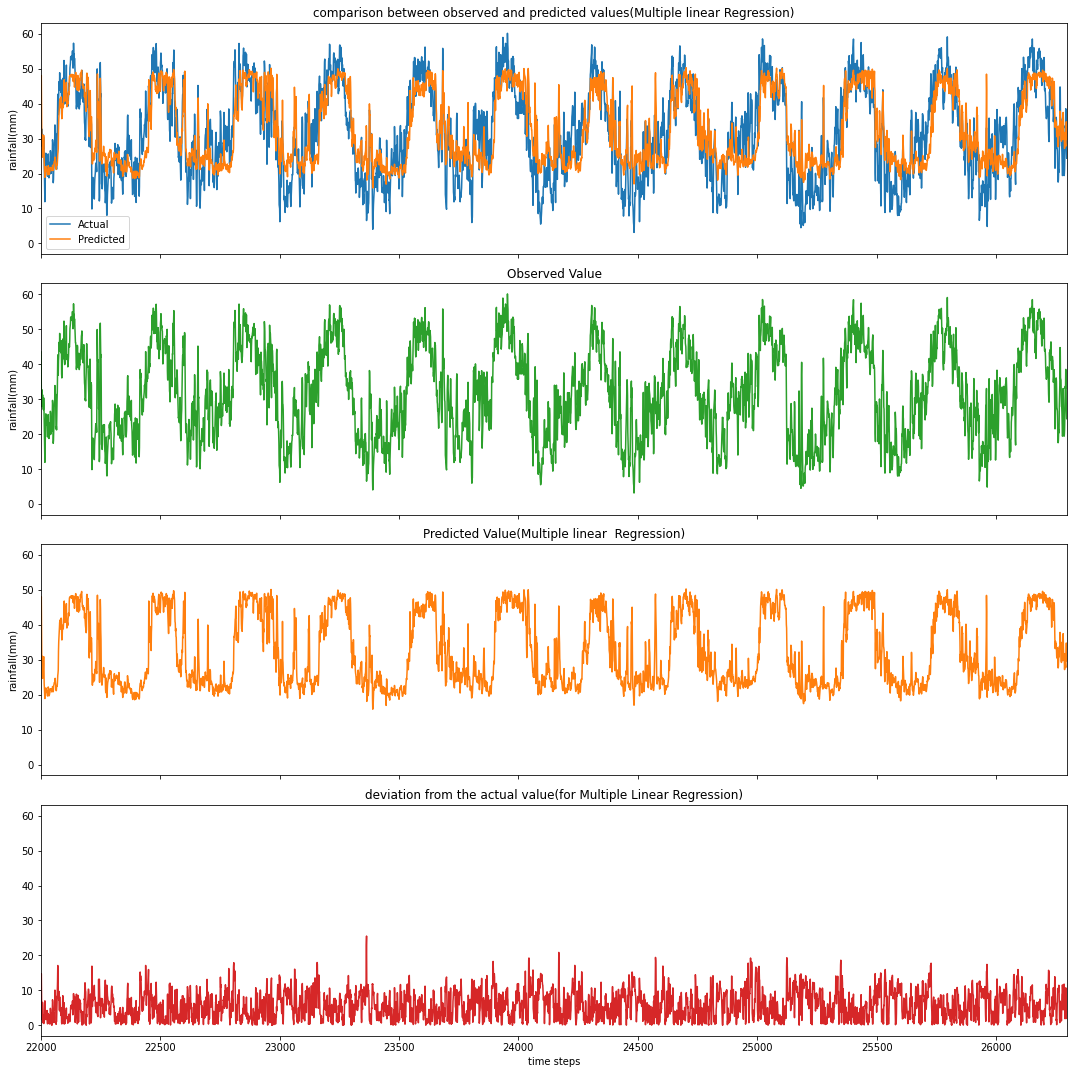

In [ ]:
from sklearn.neural_network import MLPRegressor
regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)
y_pred_mlp = regr.predict(X_test)
df_mlp = pd.DataFrame({'Actual': y_test,'Predicted': y_pred_mlp})
print(df_mlp)

print(y_test,y_pred_mlp)

fig1, (ax4, ax5, ax6, ax7) = plt.subplots(4,sharex=True, sharey=True)
fig1.set_figheight(15)
fig1.set_figwidth(15)
#fig.suptitle('Rainfall Forecast')
ax4.plot(y_test)
ax4.plot(df_mlp['Predicted'])
ax4.set_title('comparison between observed and predicted values(Multiple linear Regression)')
ax4.legend(['Actual','Predicted'])
ax4.set_ylabel('rainfall(mm)')
ax5.plot(y_test, 'tab:green')
ax5.set_ylabel('rainfall(mm)')
ax5.set_title('Observed Value')
ax6.plot(df_mlp['Predicted'], 'tab:orange')
ax6.set_ylabel('rainfall(mm)')
ax6.set_title('Predicted Value(Multiple linear  Regression)')
ax7.plot(abs(y_test-df_mlp['Predicted']), 'tab:red')
ax7.set_title('deviation from the actual value(for Multiple Linear Regression)')
ax7.set_xlabel('time steps')
plt.xlim(22000,26298)
#plt.xticks(list(range(0,init_data.shape[0],400)))
fig1.tight_layout(pad=1.0)
plt.show()




In [ ]:
print("error values for MLPRegression predictions:")
print('\tMean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_mlp))
print('\tMean Squared Error:', metrics.mean_squared_error(y_test, y_pred_mlp))
print('\tRoot Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_mlp)))

#print("\n\nerror values for LSTM predictions:")
#print('\tMean Absolute Error:', metrics.mean_absolute_error(test_y[:,2], yhat[:,2]))
#print('\tMean Squared Error:', metrics.mean_squared_error(test_y[:,2], yhat[:,2]))
#print('\tRoot Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y[:,2], yhat[:,2])))

error values for MLPRegression predictions:
	Mean Absolute Error: 5.709492030551177
	Mean Squared Error: 47.695629525912366
	Root Mean Squared Error: 6.906202250579718


**prediction using Support Vector Regression**

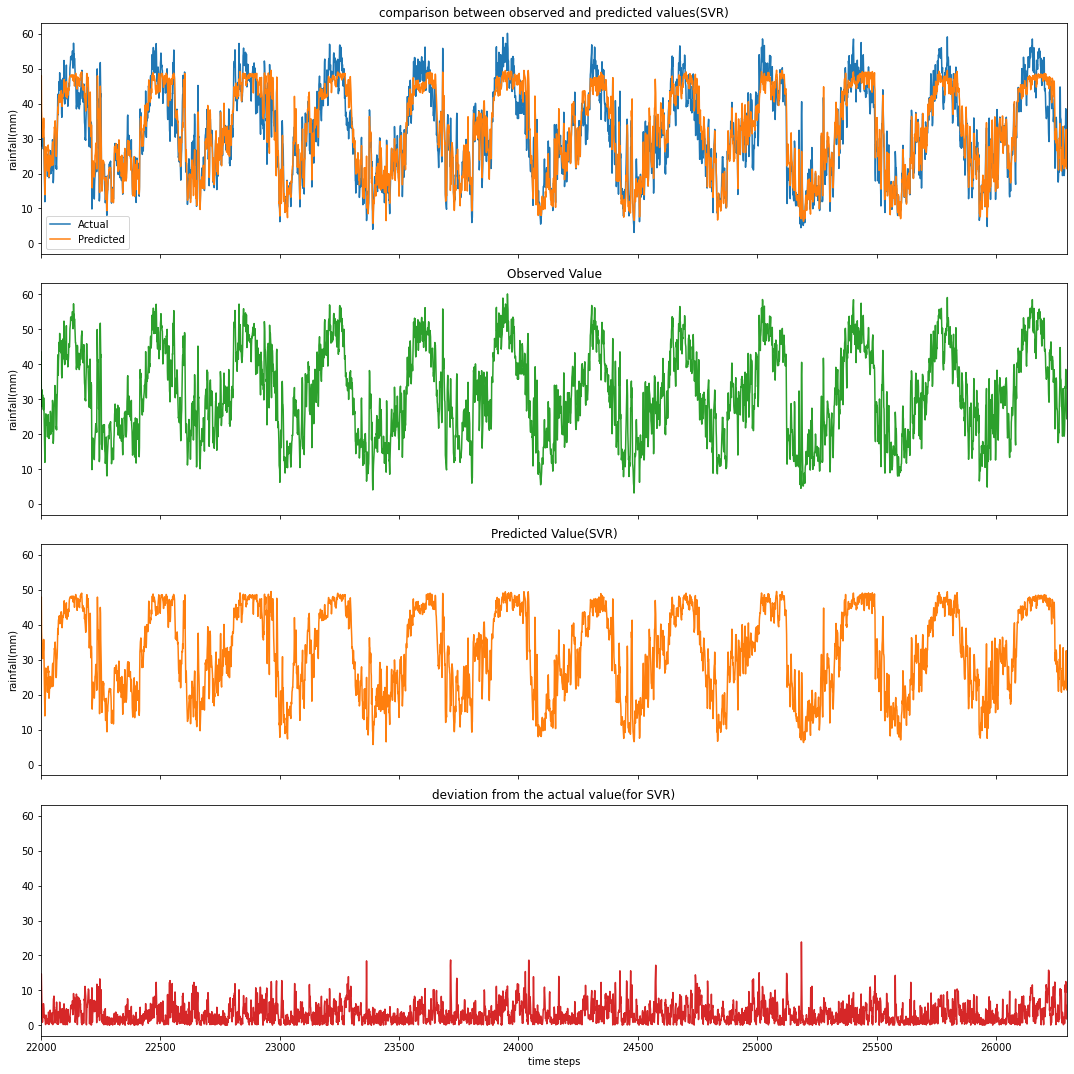

In [ ]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
n_samples, n_features = init_data.shape[0], 2
regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
regr.fit(X_train, y_train)
#Pipeline(steps=[('standardscaler', StandardScaler()),('svr', SVR(epsilon=0.2))])
y_pred_svr = regr.predict(X_test)
df_svr = pd.DataFrame({'Actual':y_test,'Predicted': y_pred_svr})
df_svr

fig1, (ax4, ax5, ax6, ax7) = plt.subplots(4,sharex=True, sharey=True)
fig1.set_figheight(15)
fig1.set_figwidth(15)
#fig.suptitle('Rainfall Forecast')
ax4.plot(y_test)
ax4.plot(df_svr['Predicted'])
ax4.set_title('comparison between observed and predicted values(SVR)')
ax4.legend(['Actual','Predicted'])
ax4.set_ylabel('rainfall(mm)')
ax5.plot(y_test, 'tab:green')
ax5.set_ylabel('rainfall(mm)')
ax5.set_title('Observed Value')
ax6.plot(df_svr['Predicted'], 'tab:orange')
ax6.set_ylabel('rainfall(mm)')
ax6.set_title('Predicted Value(SVR)')
ax7.plot(abs(y_test-df_svr['Predicted']), 'tab:red')
ax7.set_title('deviation from the actual value(for SVR)')
ax7.set_xlabel('time steps')
plt.xlim(22000,26298)
#plt.xticks(list(range(0,init_data.shape[0],400)))
fig1.tight_layout(pad=1.0)
plt.show()


In [ ]:
print("error values for SVRegression predictions:")
print('\tMean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_svr))
print('\tMean Squared Error:', metrics.mean_squared_error(y_test, y_pred_svr))
print('\tRoot Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_svr)))

#print("\n\nerror values for LSTM predictions:")
#print('\tMean Absolute Error:', metrics.mean_absolute_error(test_y[:,2], yhat[:,2]))
#print('\tMean Squared Error:', metrics.mean_squared_error(test_y[:,2], yhat[:,2]))
#print('\tRoot Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y[:,2], yhat[:,2])))

error values for SVRegression predictions:
	Mean Absolute Error: 3.090655767809063
	Mean Squared Error: 16.38507406218488
	Root Mean Squared Error: 4.04784807795264


In [ ]:
from sklearn import linear_model
reg = linear_model.Ridge(alpha=.5)
reg.fit(X_train,y_train)
y_pred_ridge = reg.predict(X_test)
df_ridge = pd.DataFrame({'Actual':y_test,'Predicted': y_pred_ridge})
df_ridge

,Actual,Predicted
7154,53.130005,47.236323
13063,51.679993,49.696446
17768,44.509995,48.787036
21681,25.569992,26.771088
9329,52.780000,45.505752
...,...,...
18830,49.940002,45.765210
7704,16.829987,19.714661
16637,40.610000,44.180568
13732,50.459990,47.794140


In [ ]:
print("error values for SVRegression predictions:")
print('\tMean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_ridge))
print('\tMean Squared Error:', metrics.mean_squared_error(y_test, y_pred_ridge))
print('\tRoot Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_ridge)))

error values for SVRegression predictions:
	Mean Absolute Error: 3.4014802030809355
	Mean Squared Error: 18.876951691488912
	Root Mean Squared Error: 4.344761407889841


In [ ]:
'''
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(5,sharex=True, sharey=True)
fig.set_figheight(15)
fig.set_figwidth(15)
#fig.suptitle('Rainfall Forecast')
ax0.plot(test_y[:,2])
ax0.plot(yhat[:,2])
ax0.set_title('comparison between observed and predicted values(LSTM)')
ax0.legend(['Actual','Predicted'])
ax0.set_ylabel('rainfall(mm)')
ax1.plot(test_y[:,2], 'tab:green')
ax1.set_ylabel('rainfall(mm)')
ax1.set_title('Observed Value')
ax2.plot(yhat[:,2], 'tab:orange')
ax2.set_ylabel('rainfall(mm)')
ax2.set_title('Predicted Value(LSTM)')
#ax3.plot(abs(test_y[:,2]-yhat[:,2]), 'tab:red')
#ax3.set_title('deviation from the actual value(for LSTM)')
ax3.plot(y_pred_lr, 'tab:grey')
ax3.set_ylabel('rainfall(mm)')
ax3.set_title('Predicted Value(Linear Regression)')
ax4.plot(y_pred_svr, 'tab:cyan')
ax4.set_ylabel('rainfall(mm)')
ax4.set_title('Predicted Value(SVRegression)')
ax4.set_xlabel('time steps')
#plt.xticks(list(range(0,init_data.shape[0],400)))
fig.tight_layout(pad=1.0)
plt.show()
'''

"\nfig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(5,sharex=True, sharey=True)\nfig.set_figheight(15)\nfig.set_figwidth(15)\n#fig.suptitle('Rainfall Forecast')\nax0.plot(test_y[:,2])\nax0.plot(yhat[:,2])\nax0.set_title('comparison between observed and predicted values(LSTM)')\nax0.legend(['Actual','Predicted'])\nax0.set_ylabel('rainfall(mm)')\nax1.plot(test_y[:,2], 'tab:green')\nax1.set_ylabel('rainfall(mm)')\nax1.set_title('Observed Value')\nax2.plot(yhat[:,2], 'tab:orange')\nax2.set_ylabel('rainfall(mm)')\nax2.set_title('Predicted Value(LSTM)')\n#ax3.plot(abs(test_y[:,2]-yhat[:,2]), 'tab:red')\n#ax3.set_title('deviation from the actual value(for LSTM)')\nax3.plot(y_pred_lr, 'tab:grey')\nax3.set_ylabel('rainfall(mm)')\nax3.set_title('Predicted Value(Linear Regression)')\nax4.plot(y_pred_svr, 'tab:cyan')\nax4.set_ylabel('rainfall(mm)')\nax4.set_title('Predicted Value(SVRegression)')\nax4.set_xlabel('time steps')\n#plt.xticks(list(range(0,init_data.shape[0],400)))\nfig.tight_layout(pad=1.